In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import pydicom
from skimage import io

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
95287,00024999_000.png,No Finding,0,24999,22,F,PA,2544,3056,0.139,0.139,NaN
49463,00012549_003.png,Atelectasis|Fibrosis|Infiltration,3,12549,60,M,PA,2838,2991,0.143,0.143,NaN
82611,00020318_025.png,No Finding,25,20318,60,M,PA,2992,2991,0.143,0.143,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4005,00019766_001.png,Infiltration,1,19766,037Y,M,PA,3056,2544,0.139,0.139
481,00002524_013.png,Effusion,13,2524,051Y,M,AP,2500,2048,0.171,0.171
1246,00006537_000.png,Cardiomegaly,0,6537,061Y,F,PA,2048,2500,0.171,0.171


In [6]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
55833,00013968_009.png,Infiltration,9,13968,26,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
99266,00026246_000.png,No Finding,0,26246,5,F,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
78846,00019363_010.png,No Finding,10,19363,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
all_xray_df['pneumonia_class'] = np.where(all_xray_df['Pneumonia'], 1, 0)
all_xray_df

positive = all_xray_df.loc[all_xray_df['pneumonia_class']==1]
negative = all_xray_df.loc[all_xray_df['pneumonia_class']==0].sample(len(positive))
df = positive.append(negative)
# Make the y_column be a string to avoid TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
df['pneumonia_class'] = df['pneumonia_class'].astype(str)
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57900,00014345_001.png,No Finding,1,14345,33,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
65175,00016092_005.png,No Finding,5,16092,33,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
65963,00016291_047.png,Infiltration,47,16291,54,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
21508,00005722_051.png,Edema,51,5722,40,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


(array([63340.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 48780.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

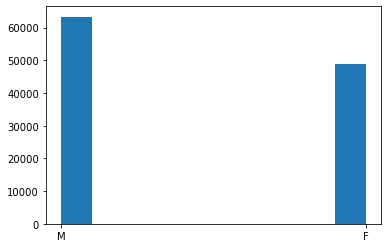

In [4]:
## EDA

# Patient Gender Distribution
plt.hist(all_xray_df['Patient Gender'])

(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

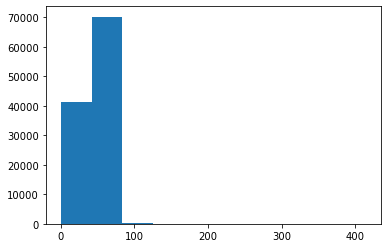

In [5]:
# Patient Age Distribution
plt.hist(all_xray_df['Patient Age'].astype(int))

(array([67310.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 44810.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

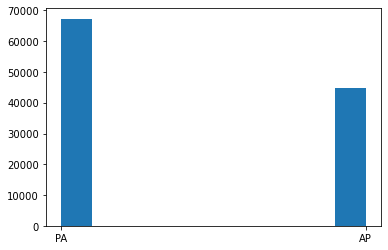

In [6]:
# View Position Distribution
plt.hist(all_xray_df['View Position'])

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


[Text(0, 0.5, 'Number of Images with Label')]

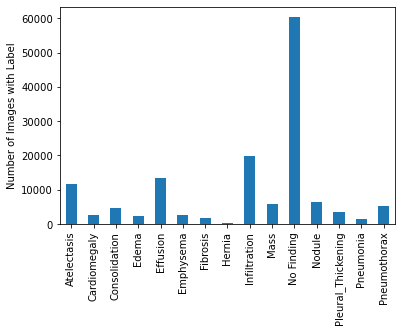

In [7]:
# Finding Labels Distribution
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

to_plot = all_xray_df[all_labels]

ax = to_plot.sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [8]:
# Number of pneumonia cases
pneumonia_cases = to_plot['Pneumonia'].sum()
print(f'Number of pneumonia cases: {pneumonia_cases}')

Number of pneumonia cases: 1431.0


In [9]:
# Number of non-pneumonia cases
non_pneumonia = len(to_plot) - pneumonia_cases
print(f'Number of non-pneumonia cases: {non_pneumonia}')

Number of non-pneumonia cases: 110689.0


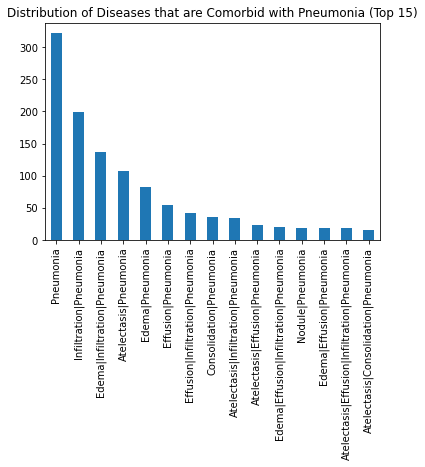

In [10]:
# The distribution of other diseases that are comorbid with pneumonia
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:15].plot(kind='bar', title='Distribution of Diseases that are Comorbid with Pneumonia (Top 15)')

In [11]:
# Number of disease per patient
number_diseases = []
for row in to_plot.iterrows():
    number_diseases.append(sum(row[1].values))
mySeries = pd.Series(number_diseases)

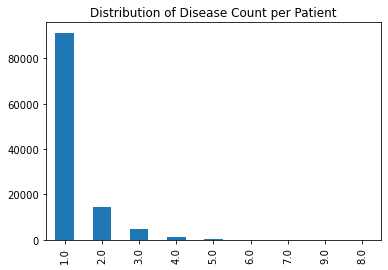

In [12]:
mySeries.value_counts().plot(kind='bar',title='Distribution of Disease Count per Patient')

In [13]:
# Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) 
# and compare distributions across diseases.
df = sample_df
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
186,00001075_004.png,Mass,4,1075,059Y,F,PA,2838,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2101,00010815_006.png,Mass,6,10815,065Y,M,PA,2842,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3225,00015900_000.png,No Finding,0,15900,066Y,F,PA,2774,2801,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Let's plot just one of each finding type

In [14]:
data_sample = pd.read_csv('sample_labels.csv')
data_sample_paths = {os.path.basename(x): x for x       
                     in glob(os.path.join('/data','images*', '*', 
                     '*.png'))}
data_sample['path'] = data_sample['Image Index'].map(data_sample_paths.get)

In [15]:
# new_df = pd.DataFrame(columns=df.columns)
new_df = data_sample
for label in all_labels:
    data = df.loc[df['Finding Labels']==label].sample(1)
    new_df = new_df.append(data)
new_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,00027370_001.png,No Finding,1,27370,036Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
101,00000569_005.png,Nodule,5,569,070Y,F,PA,2438,2615,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
602,00003098_004.png,Pleural_Thickening,4,3098,035Y,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


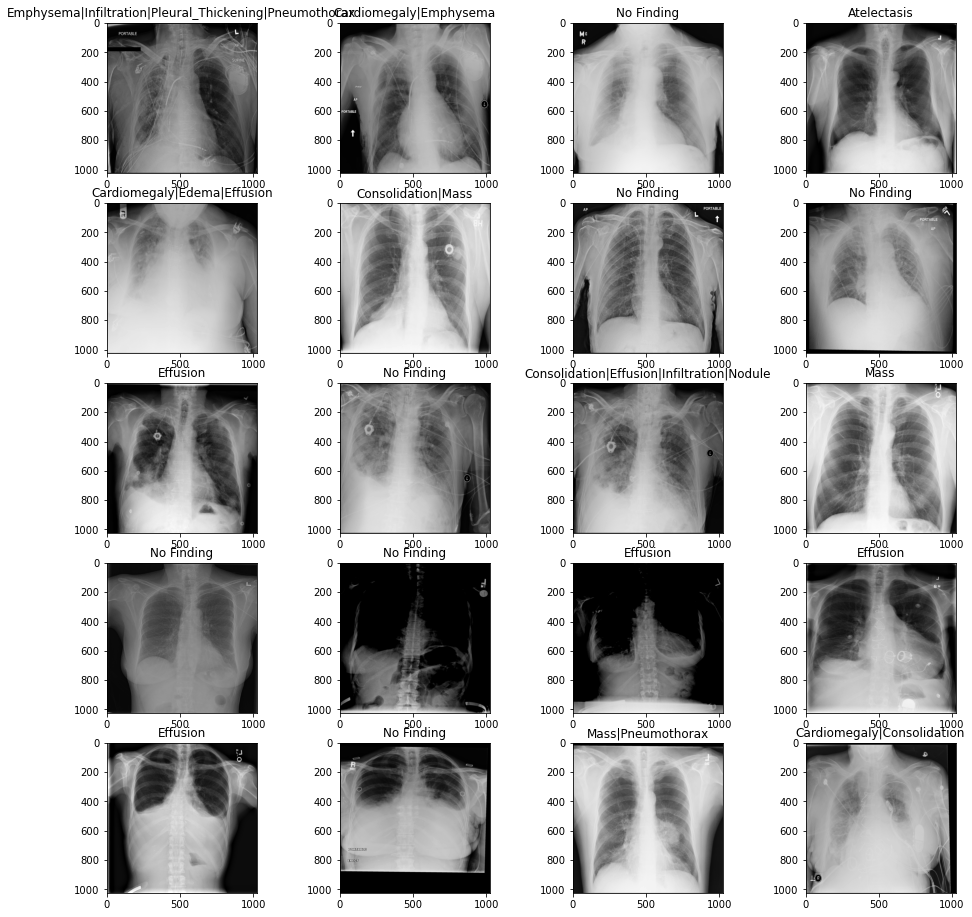

In [16]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = new_df['path']
ind=0
mean_intensities = []
std_intensities = []

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(new_df.iloc[ind]['Finding Labels'])
    mean_intensity = np.mean(img)
    mean_intensities.append(mean_intensity)
    std_intensity = np.std(img)
    std_intensities.append(std_intensity)
    new_img = img.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    ax.imshow(new_img,cmap='gray')
    ax.set_title(new_df.iloc[ind]['Finding Labels'])
    ind=ind+1

(array([2., 3., 2., 3., 1., 1., 2., 2., 1., 3.]),
 array([ 93.60135269, 102.66417038, 111.72698808, 120.78980577,
        129.85262346, 138.91544116, 147.97825885, 157.04107654,
        166.10389423, 175.16671193, 184.22952962]),
 <a list of 10 Patch objects>)

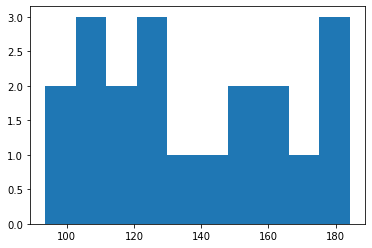

In [17]:
plt.hist(mean_intensities)

(array([1., 1., 3., 3., 4., 1., 1., 3., 1., 2.]),
 array([40.73721288, 44.32480028, 47.91238769, 51.49997509, 55.0875625 ,
        58.6751499 , 62.2627373 , 65.85032471, 69.43791211, 73.02549952,
        76.61308692]),
 <a list of 10 Patch objects>)

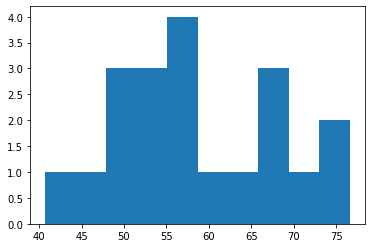

In [18]:
plt.hist(std_intensities)

# Using just Pneumonia and Healthy Cases and Comparing Distributions of Intensities

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


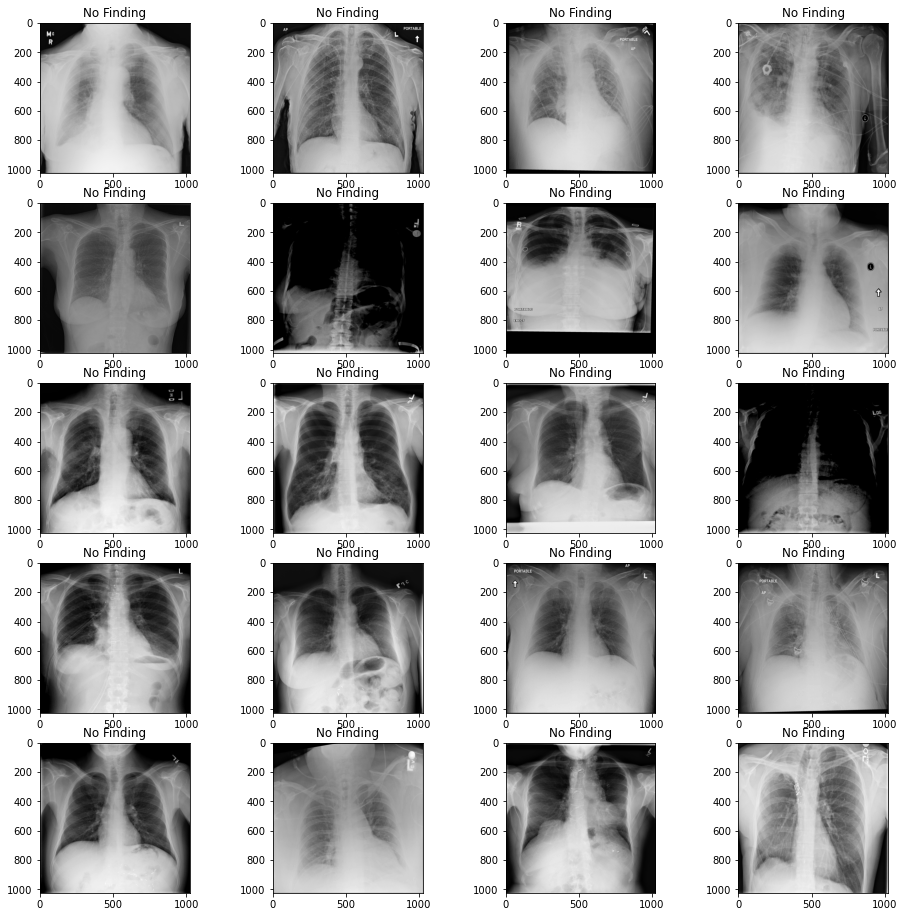

In [19]:
pndf = data_sample.loc[data_sample['Finding Labels'].isin(['Pneumonia','No Finding'])]

fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = pndf['path']
ind=0
mean_intensities = []
std_intensities = []

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(pndf.iloc[ind]['Finding Labels'])
    mean_intensity = np.mean(img)
    mean_intensities.append(mean_intensity)
    std_intensity = np.std(img)
    std_intensities.append(std_intensity)
    new_img = img.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    ax.imshow(new_img,cmap='gray')
    ax.set_title(pndf.iloc[ind]['Finding Labels'])
    ind=ind+1

(array([2., 1., 5., 3., 5., 0., 1., 1., 0., 2.]),
 array([100.37637901, 108.76169407, 117.14700913, 125.53232419,
        133.91763926, 142.30295432, 150.68826938, 159.07358444,
        167.4588995 , 175.84421456, 184.22952962]),
 <a list of 10 Patch objects>)

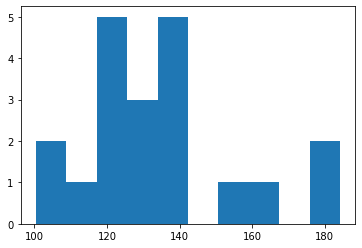

In [20]:
plt.hist(mean_intensities)

(array([2., 1., 1., 4., 3., 0., 2., 2., 3., 2.]),
 array([40.73721288, 44.32480028, 47.91238769, 51.49997509, 55.0875625 ,
        58.6751499 , 62.2627373 , 65.85032471, 69.43791211, 73.02549952,
        76.61308692]),
 <a list of 10 Patch objects>)

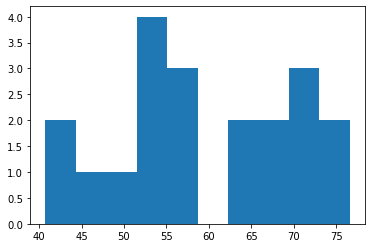

In [21]:
plt.hist(std_intensities)